In [1]:
import os, sys
sys.path.insert(1, os.path.abspath("../../../"))  # for dowhy source code

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=0, num_effect_modifiers=0,
                                    treatment_is_binary=False)
df=data['df']
df.head()

,W0,W1,W2,W3,v,y
0,0.482931,-0.867198,1.284895,-0.558172,2.115803,21.397128
1,-0.895418,-1.195202,0.465019,-0.335279,-7.677731,-81.947313
2,0.256717,1.965423,-0.052337,0.115909,7.141618,77.758037
3,-0.450275,0.958606,-1.267065,-2.238131,-11.432170,-124.696546
4,-1.168103,0.110812,0.385427,0.678330,1.921300,20.701924


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v'] on outcome ['y']


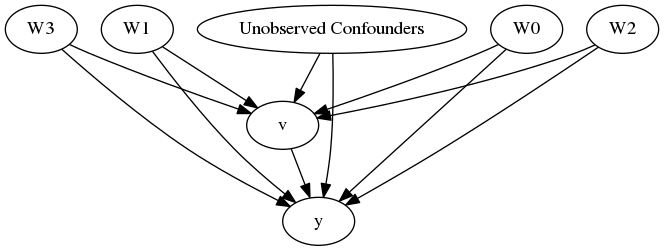

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W3', 'W1', 'W2', 'Unobserved Confounders', 'W0']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W3,W1,W2,W0))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W3,W1,W2,W0,U) = P(y|v,W3,W1,W2,W0)



In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
econml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCate",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(econml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W3+W1+W2+W0


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W3,W1,W2,W0))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W3,W1,W2,W0,U) = P(y|v,W3,W1,W2,W0)

## Realized estimand
b: y~v+W3+W1+W2+W0
## Estimate
Value: 10.821853268637884



In [8]:
print("True causal estimate is", data["ate"])

True causal estimate is 10.0


### Linear Model 

In [9]:
linear_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(linear_estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v+W3+W1+W2+W0


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W3,W1,W2,W0))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W3,W1,W2,W0,U) = P(y|v,W3,W1,W2,W0)

## Realized estimand
b: y~v+W3+W1+W2+W0
## Estimate
Value: 9.999999999999982



## Refuting the estimate

### Random 

In [10]:
res_random=model.refute_estimate(identified_estimand, econml_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W3+W1+W2+W0+w_random


Refute: Add a Random Common Cause
Estimated effect:(10.821853268637884,)
New effect:(10.822928086041284,)



### Adding an unobserved common cause variable

In [11]:
res_unobserved=model.refute_estimate(identified_estimand, econml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W3+W1+W2+W0


Refute: Add an Unobserved Common Cause
Estimated effect:(10.821853268637884,)
New effect:(10.458826553981226,)



#### Replacing treatment with a random (placebo) variable

In [12]:
res_placebo=model.refute_estimate(identified_estimand, econml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W3+W1+W2+W0


Refute: Use a Placebo Treatment
Estimated effect:(10.821853268637884,)
New effect:(0.0,)



#### Removing a random subset of the data

In [13]:
res_subset=model.refute_estimate(identified_estimand, econml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W3+W1+W2+W0


Refute: Use a subset of data
Estimated effect:(10.821853268637884,)
New effect:(10.818768700438671,)

